# **Alzimers Detection**


# **Different stages of Alzheimer by CNN and Transfer Learining**

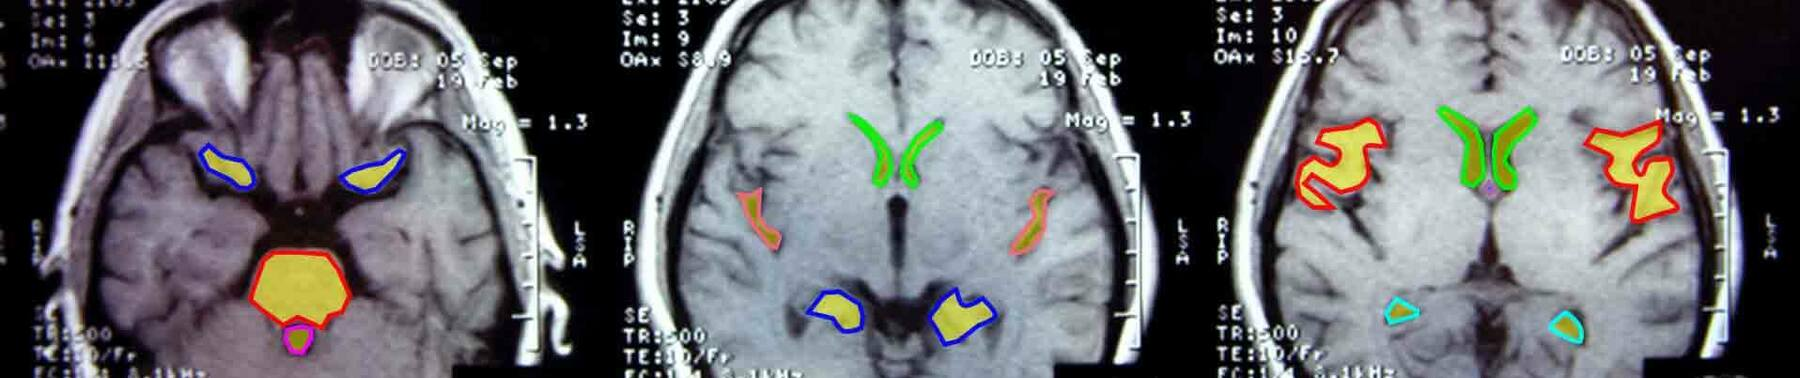

## Load train and test data sets from images


In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
tfl = tf.keras.layers

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
print("load train data set:")
train_ds = image_dataset_from_directory("C:/Users/Tejus/Downloads/archive (6)/Alzheimer_s Dataset/train",
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE,
                                        color_mode="grayscale",
                                        seed=0)
print("load test data set:")
test_ds = image_dataset_from_directory("C:/Users/Tejus/Downloads/archive (6)/Alzheimer_s Dataset/test",
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE,
                                        color_mode="grayscale",
                                        seed=0)

load train data set:
Found 5121 files belonging to 4 classes.
load test data set:
Found 1279 files belonging to 4 classes.


class names are ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


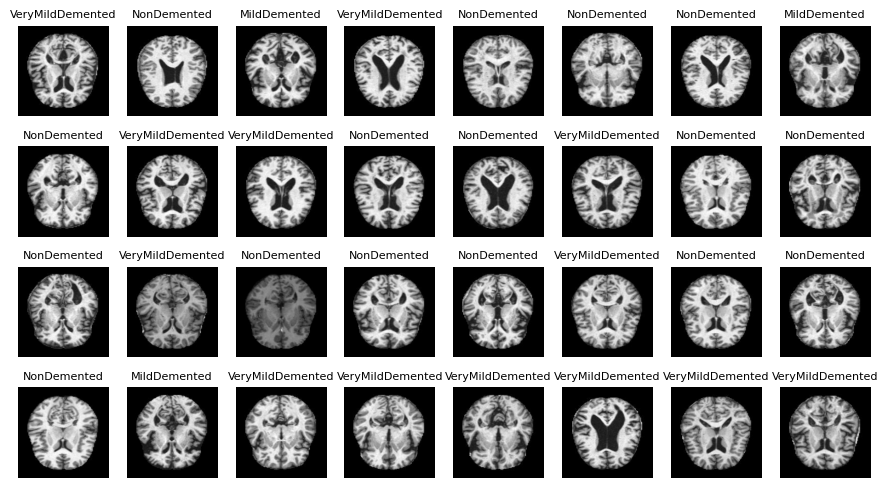

In [5]:
class_names = train_ds.class_names
print(f"class names are {class_names}")
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(11, 6))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

images, labels = next(iter(train_ds))
for i in range(32):
    a = ax.flat[i]
    a.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    a.set_title(class_names[labels[i]],fontsize = 8)
    a.set_axis_off()

plt.show()

### Data Distribution


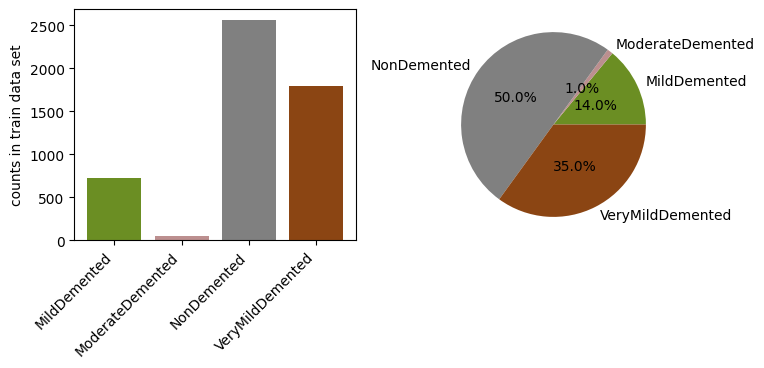

In [6]:
index = np.array([],dtype="int32");
for element in train_ds.as_numpy_iterator():
    index = np.append(index,element[1])

unique, counts = np.unique(index, return_counts=True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
colors=['olivedrab', 'rosybrown', 'gray', 'saddlebrown']
ax[0].bar(unique,counts,color=colors)
ax[0].set_ylabel(f"counts in train data set")
ax[0].set_xticks(np.arange(len(unique)))
ax[0].set_xticklabels([class_names[i] for i in unique], rotation=45, ha='right')

ax[1].pie(counts/counts.sum(), labels=[class_names[i] for i in unique],
          autopct='%1.1f%%',pctdistance=0.5, labeldistance=1.1, colors=colors)


plt.show()


CNN by Sequential API

In [7]:
def conv_block(numfilters, padding='same'):
    model_cb = tf.keras.Sequential([
        tfl.Conv2D(filters=numfilters, kernel_size=3, strides=1, padding=padding, activation='relu'),
        tfl.BatchNormalization(axis=-1),
        tfl.MaxPooling2D(pool_size=2)
    ])
    return model_cb

def dense_block(numunits):
    model_db = tf.keras.Sequential([
        tfl.Dense(numunits, activation='relu'),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.2)
    ])
    return model_db

IMG_SHAPE = IMG_SIZE + (1,)
model_sequential = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SHAPE),
    conv_block(16),
    conv_block(32),
    conv_block(64),
    conv_block(128),
    conv_block(256),
    tfl.Flatten(),
    dense_block(128),
    dense_block(64),
    tfl.Dense(units=4, activation='linear',name='output-layer')
])
model_sequential.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 80, 80, 16)        224       
                                                                 
 sequential_1 (Sequential)   (None, 40, 40, 32)        4768      
                                                                 
 sequential_2 (Sequential)   (None, 20, 20, 64)        18752     
                                                                 
 sequential_3 (Sequential)   (None, 10, 10, 128)       74368     
                                                                 
 sequential_4 (Sequential)   (None, 5, 5, 256)         296192    
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 sequential_5 (Sequential)   (None, 128)              

In [8]:
model_sequential.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [9]:
def scheduler(epoch, lr):
    return lr*(0.1**(0.05*epoch))

my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    tf.keras.callbacks.ModelCheckpoint("alzheimer_model_sequential.h5", monitor='val_accuracy', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

In [11]:
history_sequential = model_sequential.fit(train_ds, validation_data=test_ds,
                                          callbacks=my_callbacks, epochs=30,
                                          batch_size=32, verbose=2)
print("Finished!")

Epoch 1/30


161/161 - 87s - loss: 1.0845 - accuracy: 0.5798 - val_loss: 1.3597 - val_accuracy: 0.4066 - lr: 0.0010 - 87s/epoch - 543ms/step
Epoch 2/30


c:\Users\Tejus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


161/161 - 89s - loss: 0.5687 - accuracy: 0.7811 - val_loss: 1.1172 - val_accuracy: 0.6044 - lr: 8.9125e-04 - 89s/epoch - 551ms/step
Epoch 3/30
161/161 - 87s - loss: 0.2816 - accuracy: 0.9037 - val_loss: 0.9768 - val_accuracy: 0.6701 - lr: 7.0795e-04 - 87s/epoch - 543ms/step
Epoch 4/30
161/161 - 90s - loss: 0.0948 - accuracy: 0.9734 - val_loss: 1.1705 - val_accuracy: 0.6630 - lr: 5.0119e-04 - 90s/epoch - 557ms/step
Epoch 5/30
161/161 - 92s - loss: 0.0408 - accuracy: 0.9906 - val_loss: 0.9577 - val_accuracy: 0.7107 - lr: 3.1623e-04 - 92s/epoch - 572ms/step
Epoch 6/30
161/161 - 88s - loss: 0.0207 - accuracy: 0.9988 - val_loss: 1.0285 - val_accuracy: 0.7091 - lr: 1.7783e-04 - 88s/epoch - 547ms/step
Epoch 7/30
161/161 - 88s - loss: 0.0166 - accuracy: 0.9984 - val_loss: 1.0251 - val_accuracy: 0.7138 - lr: 8.9125e-05 - 88s/epoch - 547ms/step
Epoch 8/30
161/161 - 89s - loss: 0.0136 - accuracy: 0.9992 - val_loss: 1.0200 - val_accuracy: 0.7146 - lr: 3.9811e-05 - 89s/epoch - 552ms/step
Epoch 9/30

In [44]:
alzheimer_model_sequential = tf.keras.models.load_model('alzheimer_model_sequential.h5')
alzheimer_model_sequential.trainable = False
print(f"Train accuracy = {alzheimer_model_sequential.evaluate(train_ds,verbose=0)[1]*100:.2f}%")
print(f"Valid accuracy = {alzheimer_model_sequential.evaluate(test_ds,verbose=0)[1]*100:.2f}%")

Train accuracy = 100.00%
Valid accuracy = 72.87%


1/1 [==============================] - 0s 215ms/step


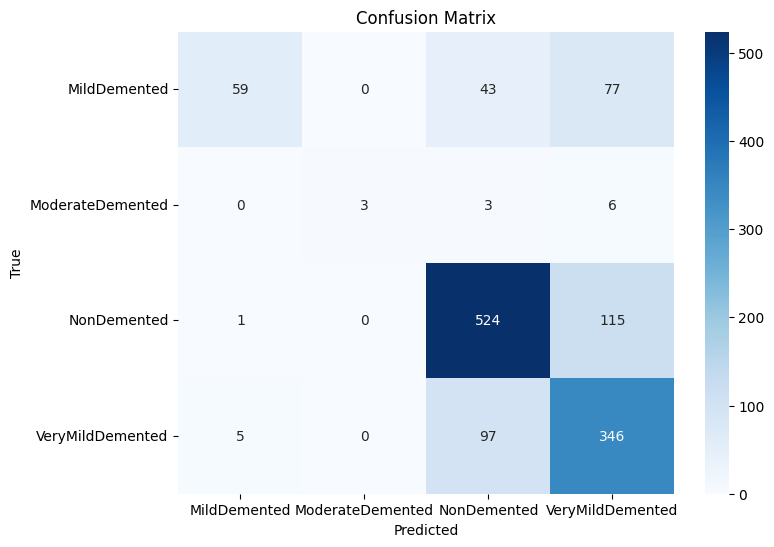

Classification Report:
                   precision    recall  f1-score   support

    MildDemented       0.91      0.33      0.48       179
ModerateDemented       1.00      0.25      0.40        12
     NonDemented       0.79      0.82      0.80       640
VeryMildDemented       0.64      0.77      0.70       448

        accuracy                           0.73      1279
       macro avg       0.83      0.54      0.60      1279
    weighted avg       0.75      0.73      0.72      1279

F1 Score: 0.72
Precision: 0.75
Recall: 0.73


In [45]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the model
alzheimer_model_sequential = tf.keras.models.load_model('alzheimer_model_sequential.h5')
alzheimer_model_sequential.trainable = False

# Define a function to evaluate the model and print various metrics
def evaluate_model(model, test_dataset):
    # Get true labels and predictions
    true_labels = []
    predictions = []

    for images, labels in test_dataset:
        true_labels.extend(labels.numpy())
        predictions.extend(np.argmax(model.predict(images), axis=1))

    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    class_report = classification_report(true_labels, predictions, target_names=class_names)
    print("Classification Report:\n", class_report)

    # F1 Score, Precision, and Recall
    f1 = f1_score(true_labels, predictions, average='weighted')
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')

    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

# Evaluate the model on the test dataset
evaluate_model(alzheimer_model_sequential, test_ds)


In [50]:
# Iterate through the test dataset and print original vs. predicted class labels
for images, labels in test_ds:
    predicted_labels = np.argmax(alzheimer_model_sequential.predict(images), axis=1)
    
    for true_label, predicted_label in zip(labels.numpy(), predicted_labels):
        print(f"Original: {class_names[true_label]}, Predicted: {class_names[predicted_label]}")

1/1 [==============================] - 0s 103ms/step
Original: VeryMildDemented, Predicted: VeryMildDemented
Original: VeryMildDemented, Predicted: VeryMildDemented
Original: VeryMildDemented, Predicted: VeryMildDemented
Original: NonDemented, Predicted: NonDemented
Original: NonDemented, Predicted: VeryMildDemented
Original: NonDemented, Predicted: NonDemented
Original: VeryMildDemented, Predicted: VeryMildDemented
Original: VeryMildDemented, Predicted: VeryMildDemented
Original: NonDemented, Predicted: NonDemented
Original: VeryMildDemented, Predicted: VeryMildDemented
Original: NonDemented, Predicted: NonDemented
Original: NonDemented, Predicted: VeryMildDemented
Original: NonDemented, Predicted: VeryMildDemented
Original: VeryMildDemented, Predicted: NonDemented
Original: VeryMildDemented, Predicted: VeryMildDemented
Original: NonDemented, Predicted: VeryMildDemented
Original: NonDemented, Predicted: NonDemented
Original: VeryMildDemented, Predicted: VeryMildDemented
Original: Very

# Transfer learning

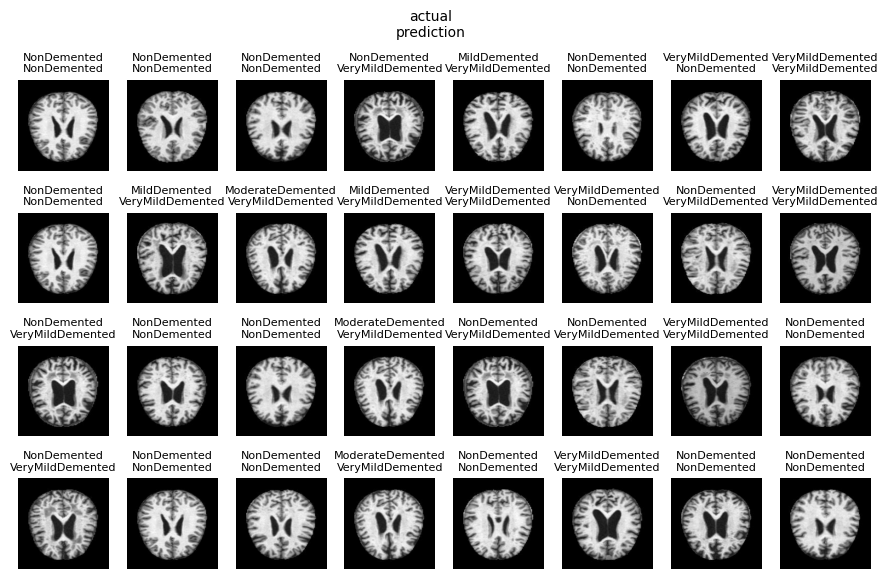

In [51]:
alzheimer_model_inception = model #tf.keras.models.load_model('alzheimer_model_inception.h5')
alzheimer_model_inception.trainable = False
image_batch, label_batch = next(iter(test_ds_OHE))
preds_batch = alzheimer_model_inception(image_batch).numpy()
yhat_batch = np.argmax(preds_batch,axis=1)
m = image_batch.shape[0]
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(11, 6.5))
fig.subplots_adjust(wspace=0.2, hspace=0.3)

from termcolor import colored
for a in ax.flat:
    random_index = np.random.randint(m)
    a.imshow(image_batch[random_index].numpy().astype("uint8"))
    print_data = class_names[np.argmax(label_batch[random_index])]
    print_pred = class_names[yhat_batch[random_index]]
    title = f"{print_data}\n{print_pred}"
    a.set_title(title,fontsize = 8)
    a.set_axis_off()

fig.suptitle('actual\nprediction',fontsize=10)
plt.show()

# Alzheimer's Disease Classification - InceptionV3

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

c:\Users\Tejus\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [63]:
base_dir = "C:/Users/Tejus/Downloads/archive (6)/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [64]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [65]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


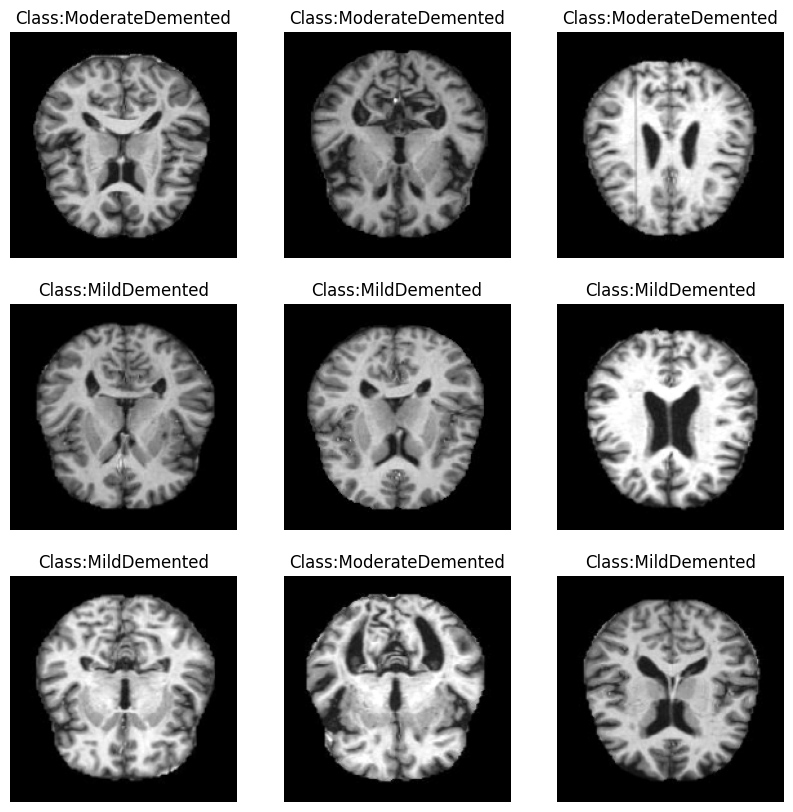

In [66]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [67]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [68]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [69]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [70]:
#Splitting the data into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [71]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [72]:
for layer in inception_model.layers:
    layer.trainable=False

In [73]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [74]:
# #Defining a custom callback function to stop training our model when accuracy goes above 99%

# class MyCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if logs.get('acc') > 0.99:
#             print("\nReached accuracy threshold! Terminating training.")
#             self.model.stop_training = True
            
# my_callback = MyCallback()

# #ReduceLROnPlateau to stabilize the training process of the model
# rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [75]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [76]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

# CALLBACKS = rop_callback
    
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout_3 (Dropout)         (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_195 (B  (None, 2048)              8192      
 atchNormalization)                                              
                                                                 
 dense_2 (Dense)             (None, 512)       

In [77]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 40

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/40
256/256 [==============================] - 186s 709ms/step - loss: 1.3296 - accuracy: 0.7500 - precision: 0.4999 - recall: 0.3015 - auc: 0.7070 - f1_score: 0.3759 - val_loss: 0.7805 - val_accuracy: 0.8279 - val_precision: 0.8289 - val_recall: 0.3926 - val_auc: 0.8847 - val_f1_score: 0.5300
Epoch 2/40
256/256 [==============================] - 162s 633ms/step - loss: 0.8974 - accuracy: 0.8126 - precision: 0.7147 - recall: 0.4167 - auc: 0.8497 - f1_score: 0.5240 - val_loss: 0.6881 - val_accuracy: 0.8444 - val_precision: 0.8423 - val_recall: 0.4644 - val_auc: 0.9141 - val_f1_score: 0.5958
Epoch 3/40
256/256 [==============================] - 162s 635ms/step - loss: 0.7937 - accuracy: 0.8315 - precision: 0.7633 - recall: 0.4728 - auc: 0.8841 - f1_score: 0.5821 - val_loss: 0.6394 - val_accuracy: 0.8564 - val_precision: 0.8249 - val_recall: 0.5405 - val_auc: 0.9250 - val_f1_score: 0.6509
Epoch 4/40
256/256 [==============================] - 172s 674ms/step - loss: 0.7297 - accurac

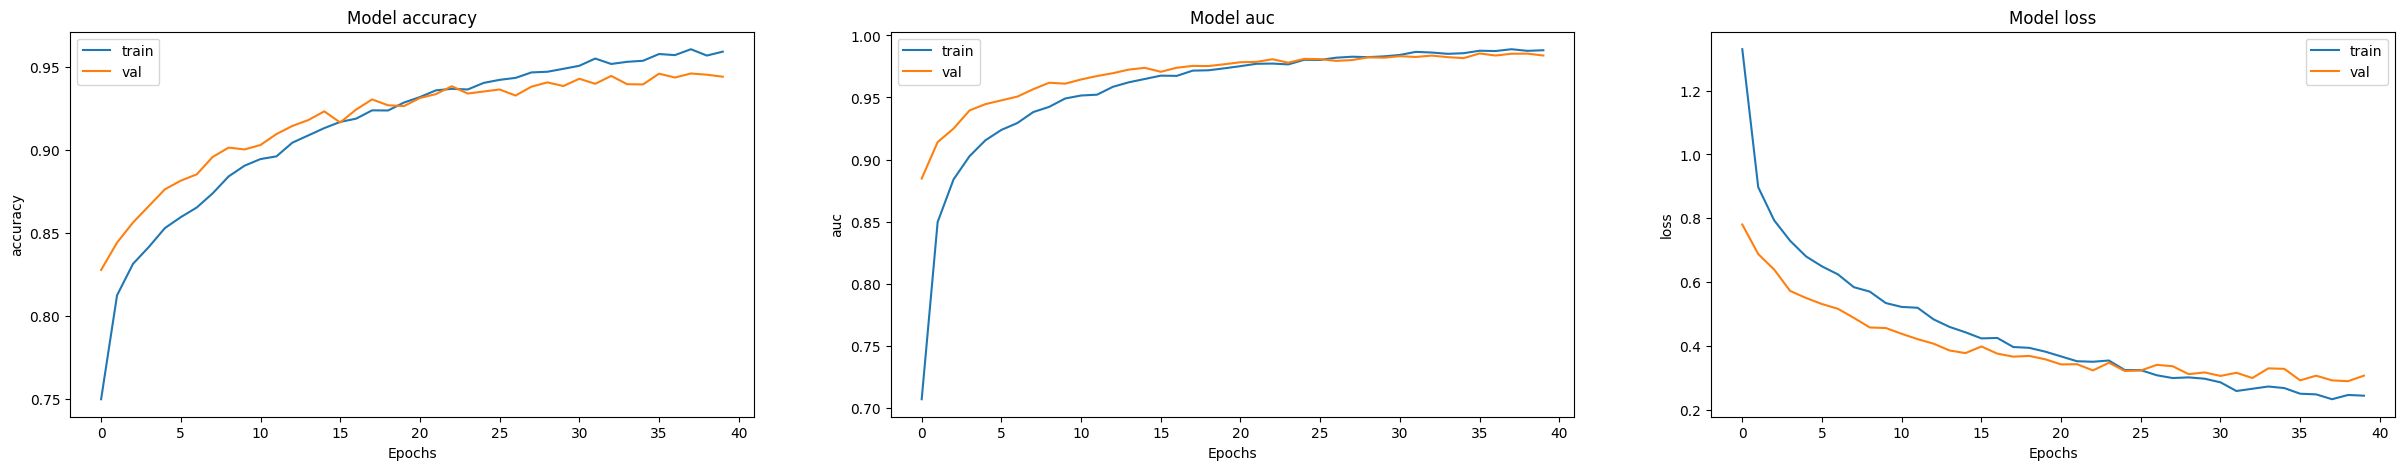

In [78]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [79]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 38s 475ms/step - loss: 0.3265 - accuracy: 0.9415 - precision: 0.8871 - recall: 0.8777 - auc: 0.9819 - f1_score: 0.8823
Testing Accuracy: 94.15%


In [91]:
#Predicting the test data
pred_labels = custom_inception_model.predict(test_data)
pred_labels

80/80 [==============================] - 40s 502ms/step


array([[2.3157015e-03, 1.1095811e-05, 5.5430322e-03, 9.9213010e-01],
       [1.0307965e-04, 9.9958354e-01, 1.0605134e-04, 2.0734992e-04],
       [1.0308293e-03, 9.4323595e-06, 1.8592183e-02, 9.8036754e-01],
       ...,
       [3.9549200e-06, 9.9994624e-01, 1.2598640e-05, 3.7172336e-05],
       [2.4504390e-02, 1.8386864e-04, 7.0980972e-01, 2.6550192e-01],
       [9.9663371e-01, 8.9589985e-06, 6.7766104e-04, 2.6796085e-03]],
      dtype=float32)

In [92]:
test_labels

array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       ...,
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0]])

In [81]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.91      0.95      0.93       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.87      0.73      0.80       662
ModerateDemented       0.76      0.85      0.80       624

       micro avg       0.88      0.88      0.88      2560
       macro avg       0.88      0.88      0.88      2560
    weighted avg       0.88      0.88      0.88      2560
     samples avg       0.88      0.88      0.88      2560



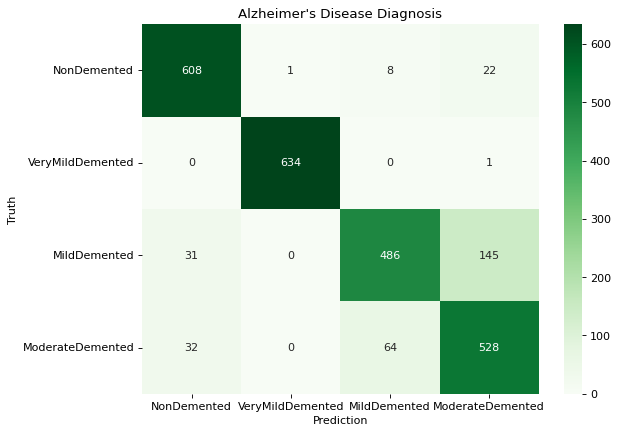

In [82]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [83]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))


Balanced Accuracy Score: 88.26 %
Matthew's Correlation Coefficient: 84.32 %


In [89]:
#Saving the model for future use

custom_inception_model_dir = work_dir + "alzheimer_inception_cnn_model"
custom_inception_model.save(custom_inception_model_dir, save_format='h5')
os.listdir(work_dir)

['alzheimer_inception_cnn_model',
 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

In [90]:
# Save the model
custom_inception_model.save("alzheimers_model1.h5")

In [5]:
pretrained_model = tf.keras.models.load_model(custom_inception_model_dir)
#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

NameError: name 'custom_inception_model_dir' is not defined

In [88]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']

SyntaxError: incomplete input (2196541448.py, line 52)